In [76]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta,date

## Data Cleaning

In [2]:
df = pd.read_csv("slice.csv")

In [3]:
df.describe()

,order_id,promo_amount,restaurant_total,user_id
count,1.613100e+04,860.000000,16131.000000,16131.000000
mean,9.879095e+06,-3.323256,31.038640,16274.023247
std,7.151461e+06,1.088695,23.130207,4452.416690
min,-7.006713e+06,-8.000000,0.000000,10000.000000
25%,1.086768e+07,-3.000000,20.890000,12417.000000
50%,1.249155e+07,-3.000000,29.000000,15380.000000
75%,1.398196e+07,-3.000000,34.620000,19695.500000
max,1.568134e+07,0.000000,1116.570000,26130.000000


In [4]:
# Format date
df['purchase_date'] = pd.to_datetime(df['purchase_date'],format='%m/%d/%y %H:%M')

In [5]:
df.head()

,order_id,source,purchase_date,shipping_type,payment_method,promo_amount,restaurant_total,user_id
0,15584975,iosapp,2019-03-03 13:08:00,Delivery,credit,NaN,13.63,12621
1,13348282,iosapp,2018-11-24 20:44:00,Pickup,credit,NaN,15.40,21165
2,12582969,google,2018-10-19 13:31:00,Pickup,credit,NaN,10.50,18651
3,12931902,iosapp,2018-11-04 14:08:00,Pickup,credit,NaN,77.52,13733
4,14884422,web,2019-02-02 21:26:00,Delivery,credit,NaN,43.57,13052


In [6]:
# Function to only get month and year of a Date Variable and put it to a string variable
def get_month_str(x): 
    a = datetime(x.year, x.month,1)
    b = a.strftime('%Y-%m')
    return b

In [7]:
# Function to get month and year of a timestamp variable
def get_month(x): return datetime(x.year, x.month,1)

In [8]:
# Function to get day, month, and year of a timestamp variable
def get_day(x): return datetime(x.year,x.month,x.day,0)

In [9]:
df['purchase_month'] = df['purchase_date'].apply(get_month)
df['purchase_day'] = df['purchase_date'].apply(get_day)
df.head()

,order_id,source,purchase_date,shipping_type,payment_method,promo_amount,restaurant_total,user_id,purchase_month,purchase_day
0,15584975,iosapp,2019-03-03 13:08:00,Delivery,credit,NaN,13.63,12621,2019-03-01,2019-03-03
1,13348282,iosapp,2018-11-24 20:44:00,Pickup,credit,NaN,15.40,21165,2018-11-01,2018-11-24
2,12582969,google,2018-10-19 13:31:00,Pickup,credit,NaN,10.50,18651,2018-10-01,2018-10-19
3,12931902,iosapp,2018-11-04 14:08:00,Pickup,credit,NaN,77.52,13733,2018-11-01,2018-11-04
4,14884422,web,2019-02-02 21:26:00,Delivery,credit,NaN,43.57,13052,2019-02-01,2019-02-02


In [10]:
# Calculate Acquire day and latest purchase
grouping = df.groupby('user_id')['purchase_day']
df['AcquireDay'] = grouping.transform('min')
df['MaxPurchase'] = grouping.transform('max')

In [11]:
# Calculate Acquire month
grouping = df.groupby('user_id')['purchase_month']
df['AcquireMonth'] = grouping.transform('min')
df['Acquire_Month'] = df['AcquireMonth'].apply(lambda x: x.strftime('%Y-%m'))

In [12]:
# Calculate Lifetime and Recency
max_date = df['purchase_day'].max()
df['Lifetime'] = df['AcquireDay'].apply(lambda x: (max_date-x)/timedelta (days=1))
df['Recency'] = df['MaxPurchase'].apply(lambda x: (max_date-x)/timedelta (days=1))

In [13]:
# Calculate order count by user
grouping = df.groupby('user_id')['order_id']
df['order_count'] = grouping.transform('count')

In [14]:
# Calculate average order per month by user
df['avg_order'] = df['order_count']*30/df['Lifetime']
df['avg_order2'] = (df['order_count']-1)*30/df['Lifetime']

In [15]:
grouping = df.groupby('user_id')['purchase_date']
df['AcquireDate'] = grouping.transform('min')

In [16]:
# Calculate Channel based on first purchase source
first_order = df[df['AcquireDate']==df['purchase_date']]
first_order = first_order[['user_id','source']]
first_order.columns = ['user_id','channel']
first_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 2 to 16130
Data columns (total 2 columns):
user_id    9999 non-null int64
channel    9999 non-null object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [17]:
data = df.join(first_order.set_index('user_id'),on = 'user_id')

In [19]:
data.groupby('channel')['order_id'].count()

channel
androidapp     662
call          2734
google        1917
iosapp        2019
web           8799
Name: order_id, dtype: int64

In [21]:
# Function to get year and month as int
def get_date_int(df, column):
    year = df[column].apply(lambda x: x.year)
    month = df[column].apply(lambda x: x.month)
    return year, month

In [22]:
purchase_year, purchase_month = get_date_int(df, 'purchase_month')
cohort_year, cohort_month = get_date_int(df, 'AcquireMonth')

In [23]:
year_diff = purchase_year - cohort_year
month_diff = purchase_month - cohort_month

In [60]:
# Calculate Cohort Index
data['Cohort_Index'] = year_diff * 12 + month_diff + 1

### User table 

Generate User Table, used to cluster users based on user behavior information

In [61]:
user_data = data[['user_id','avg_order','avg_order2','channel','order_count','Lifetime',
                 'Recency','AcquireDay']].drop_duplicates(subset='user_id',keep='first')

In [62]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 16130
Data columns (total 8 columns):
user_id        9999 non-null int64
avg_order      9999 non-null float64
avg_order2     9999 non-null float64
channel        9999 non-null object
order_count    9999 non-null int64
Lifetime       9999 non-null float64
Recency        9999 non-null float64
AcquireDay     9999 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 703.1+ KB


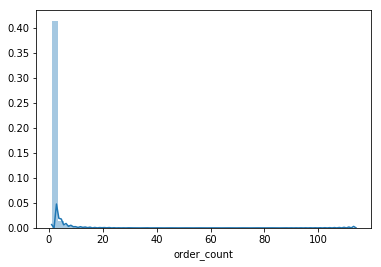

In [63]:
sns.distplot(user_data['order_count'])

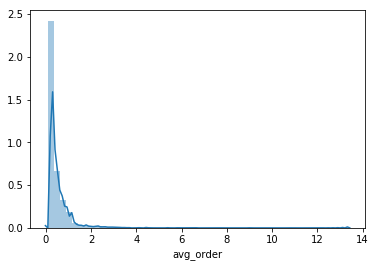

In [64]:
sns.distplot(user_data['avg_order'])

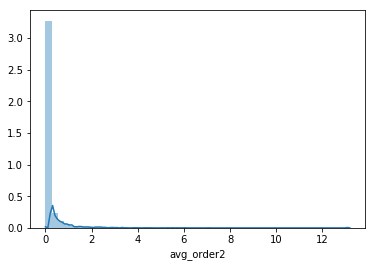

In [65]:
sns.distplot(user_data['avg_order2'])

In [105]:
user_data['avg_order'].mean()

0.4363858957010293

In [104]:
# Average order frequency after 1st month
a = user_data['avg_order2']
none_zero = a[a!=0].mean()
none_zero

0.5928207699021253

In [68]:
user_data['order_count'].mean()

1.6132613261326132

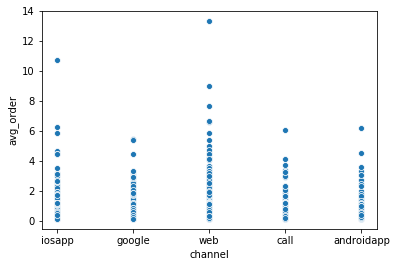

In [69]:
sns.scatterplot(x='channel', y='avg_order',data=user_data)

(736846.0, 737150.0)

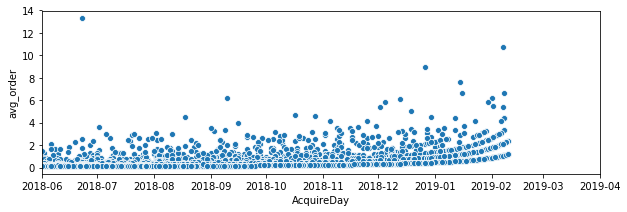

In [79]:
plt.figure(figsize=(10, 3))
sns.scatterplot(x='AcquireDay', y='avg_order',data=user_data)
plt.xlim(date(2018, 6, 1),date(2019, 4, 1))

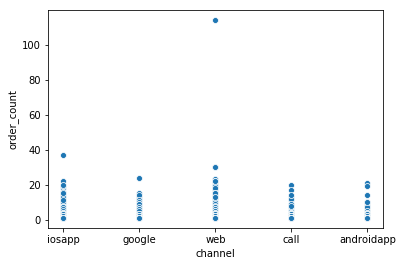

In [70]:
sns.scatterplot(x='channel', y='order_count',data=user_data)

(736846.0, 737150.0)

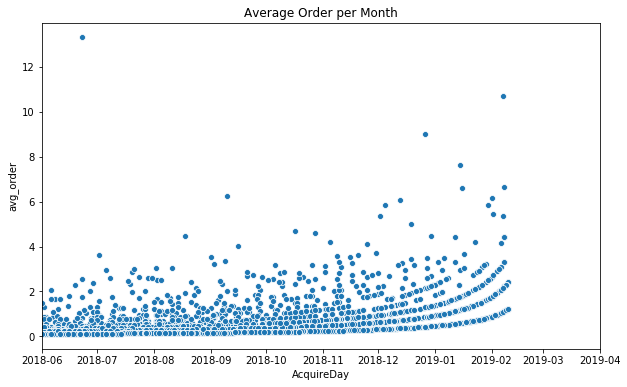

In [108]:
plt.figure(figsize=(10, 6))
plt.title('Average Order per Month')
sns.scatterplot(x='AcquireDay', y='avg_order',data=user_data)
plt.xlim(date(2018, 6, 1),date(2019, 4, 1))

## Change Channel

In [109]:
# Change the data to be different Channel here (isoapp, androindapp, web, call, google)
#data1 = data # From all channel
channel = 'iosapp'
data1 = data[data['channel'] == channel]

In [110]:
# Frequency Calculation
#user_data1 = user_data # All users
user_data1 = user_data[user_data['channel'] == channel]
num_order_month = user_data1['avg_order'].mean()
a = user_data1['avg_order2']
num_order_month2 = a[a!=0].mean()
print(num_order_month)
print(num_order_month2)

0.5828811772490821
0.7400796277143067


In [40]:
grouping = data1.groupby(['Acquire_Month', 'Cohort_Index'])
cohort_data = grouping['user_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='Acquire_Month', columns='Cohort_Index',
values='user_id')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [41]:
retention.round(3) * 100

Cohort_Index,1,2,3,4,5,6,7,8,9
Acquire_Month,,,,,,,,,
2018-06,100.0,18.8,17.8,11.9,12.9,12.9,13.9,10.9,10.9
2018-07,100.0,21.9,11.4,8.8,7.0,9.6,8.8,7.0,2.6
2018-08,100.0,14.4,14.4,15.3,10.2,7.6,12.7,2.5,NaN
2018-09,100.0,23.5,12.2,14.3,16.3,11.2,8.2,NaN,NaN
2018-10,100.0,21.9,25.0,15.6,13.5,9.4,NaN,NaN,NaN
2018-11,100.0,17.4,14.7,16.5,0.9,NaN,NaN,NaN,NaN
2018-12,100.0,26.5,13.3,7.1,NaN,NaN,NaN,NaN,NaN
2019-01,100.0,14.8,7.4,NaN,NaN,NaN,NaN,NaN,NaN
2019-02,100.0,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


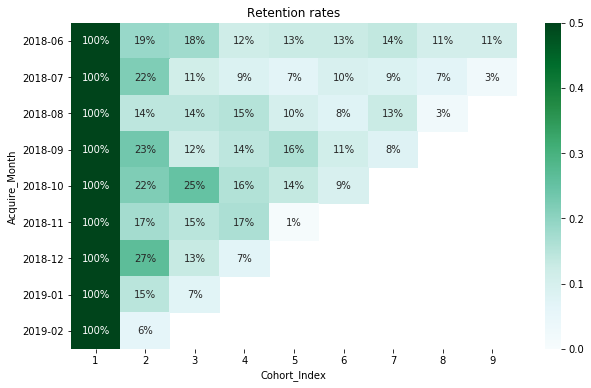

In [42]:
plt.figure(figsize=(10, 6))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True,
fmt = '.0%', vmin = 0, vmax = 0.5, cmap = 'BuGn')
plt.show()

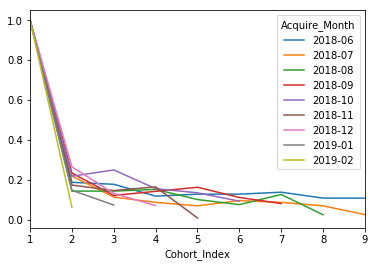

In [43]:
retention_line = retention.T
retention_line.plot()

### Getting the graph starting from index 2

In [44]:
cohort_count1 = cohort_counts
del cohort_count1[1]
cohort_sizes = cohort_count1.iloc[:,0]
retention = cohort_count1.divide(cohort_sizes, axis=0)
retention.round(3) * 100

Cohort_Index,2,3,4,5,6,7,8,9
Acquire_Month,,,,,,,,
2018-06,100.0,94.7,63.2,68.4,68.4,73.7,57.9,57.9
2018-07,100.0,52.0,40.0,32.0,44.0,40.0,32.0,12.0
2018-08,100.0,100.0,105.9,70.6,52.9,88.2,17.6,NaN
2018-09,100.0,52.2,60.9,69.6,47.8,34.8,NaN,NaN
2018-10,100.0,114.3,71.4,61.9,42.9,NaN,NaN,NaN
2018-11,100.0,84.2,94.7,5.3,NaN,NaN,NaN,NaN
2018-12,100.0,50.0,26.9,NaN,NaN,NaN,NaN,NaN
2019-01,100.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-02,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


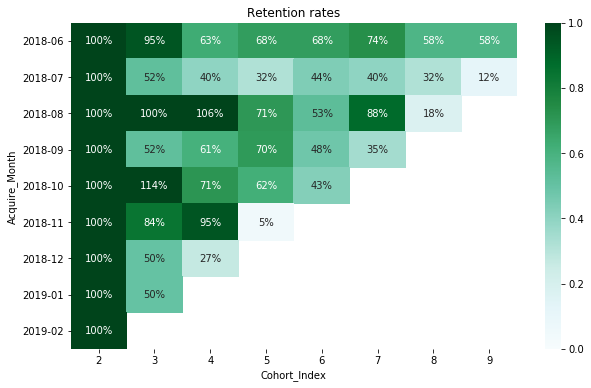

In [45]:
plt.figure(figsize=(10, 6))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True,
fmt = '.0%', vmin = 0.0, vmax = 1, cmap = 'BuGn')
plt.show()

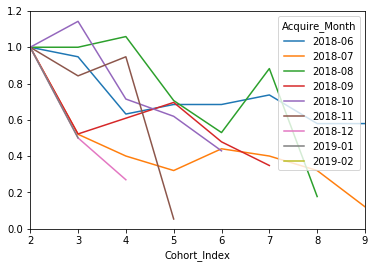

In [46]:
retention_line = retention.T
retention_line.plot()

# Clustering

In [47]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans

### Cluster by Average order

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


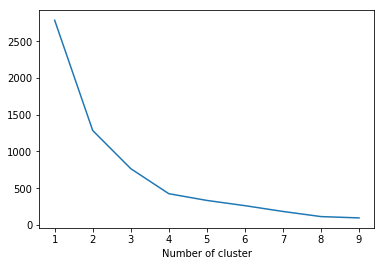

In [48]:
sse={}
user_frequency = user_data[['avg_order']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_frequency)
    user_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [49]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_data[['avg_order']])
user_data['FrequencyCluster'] = kmeans.predict(user_data[['avg_order']])

In [50]:
user_data.groupby('FrequencyCluster')['avg_order'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,7618.0,0.241864,0.113397,0.107527,0.144231,0.214286,0.315789,0.533333
1,283.0,2.284181,0.548363,1.568627,1.818182,2.195122,2.634623,4.011628
2,27.0,5.850128,2.160515,4.117647,4.444444,5.357143,6.206213,13.307393
3,2071.0,0.828839,0.236411,0.535714,0.638298,0.769231,0.967742,1.551724


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


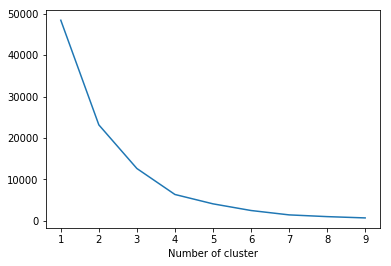

In [81]:
sse={}
user_frequency = user_data[['order_count']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_frequency)
    user_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [106]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_data[['order_count']])
user_data['CountCluster'] = kmeans.predict(user_data[['order_count']])

In [84]:
user_data.groupby('FrequencyCluster')['order_count'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,9372.0,1.226739,0.512898,1.0,1.0,1.0,1.0,3.0
1,104.0,15.423077,4.654453,11.0,12.0,14.0,18.0,37.0
2,522.0,5.586207,1.742888,4.0,4.0,5.0,7.0,10.0
3,1.0,114.000000,NaN,114.0,114.0,114.0,114.0,114.0


## Cluster into different user persona

In [ ]:
onetimer = data[data['order_count'] == 1]

In [53]:
freq_user = data[(data['order_count'] > 1) & (data['order_count'] <= 9)]

In [54]:
heavy_user = data[(data['order_count'] > 9) & (data['order_count'] < 100)]

### Change the User Segmentation here

In [102]:
df1 = freq_user

In [103]:
# Frequency Calculation
num_order_month = df1['avg_order'].mean()
a = df1['avg_order2']
num_order_month2 = a[a!=0].mean()
print(num_order_month)
print(num_order_month2)

0.9007088251751058
0.6523932088678244


### Retention table and graph

In [56]:
grouping = df1.groupby(['Acquire_Month', 'Cohort_Index'])
cohort_data = grouping['user_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='Acquire_Month', columns='Cohort_Index',
values='user_id')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [57]:
retention.round(3) * 100

Cohort_Index,1,2,3,4,5,6,7,8,9,10
Acquire_Month,,,,,,,,,,
2018-06,100.0,64.7,58.8,58.8,52.9,64.7,64.7,52.9,58.8,23.5
2018-07,100.0,81.0,95.2,76.2,71.4,71.4,76.2,71.4,23.8,NaN
2018-08,100.0,90.0,85.0,80.0,65.0,75.0,60.0,35.0,NaN,NaN
2018-09,100.0,90.9,86.4,86.4,86.4,90.9,50.0,NaN,NaN,NaN
2018-10,100.0,94.1,88.2,82.4,94.1,58.8,NaN,NaN,NaN,NaN
2018-11,100.0,93.8,93.8,93.8,56.2,NaN,NaN,NaN,NaN,NaN
2018-12,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


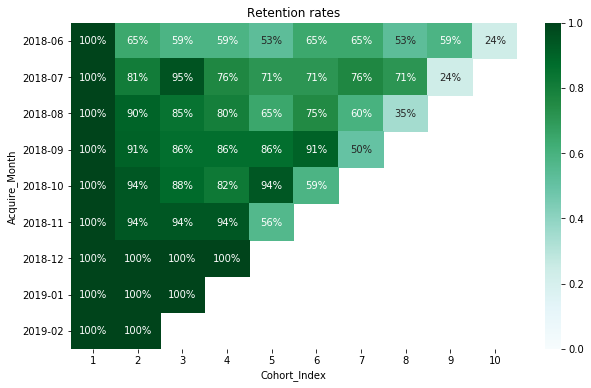

In [58]:
plt.figure(figsize=(10, 6))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True,
fmt = '.0%', vmin = 0.0, vmax = 1, cmap = 'BuGn')
plt.show()

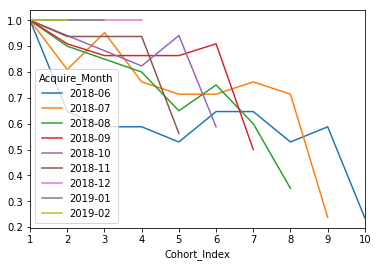

In [59]:
retention_line = retention.T
retention_line.plot()